# Line Characterization

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew

% matplotlib inline

### Functions

In [2]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

In [3]:
def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii &   (cos_theta_k_out>np.abs(np.cos(theta_max)))
    return data[ii]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary * vrot
    v_y = x_unitary * vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']/v_th
    new_data['x_frec'] += atom_velocities['y']*data['k_y']/v_th
    new_data['x_frec'] += atom_velocities['z']*data['k_z']/v_th
    
    return new_data

In [4]:
def plot_spectra(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2,label='label'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    n, b, p = plt.hist(-data_theta['x_frec']*v_th, histtype='step', 
                       fill=False, stacked=False, normed=True, color='black',
                       linewidth=lw, bins=50, alpha=alpha, label=label)
    
    x, y = [], n.copy()
    
    for i in range(len(y)):
        x.append( (b[i]+b[i+1])/2 )
    
    return np.array(x), np.array(y)


def get_spectra(data, min_theta, max_theta, v_th=12.86):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    n, b = np.histogram(-data_theta['x_frec']*v_th, normed=True, bins=50)
    
    x, y = [], n.copy()
    
    for i in range(len(y)):
        x.append( (b[i]+b[i+1])/2 )
    
    return np.array(x), np.array(y)

### Line width, skewness and intensity in the center

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', size=20)

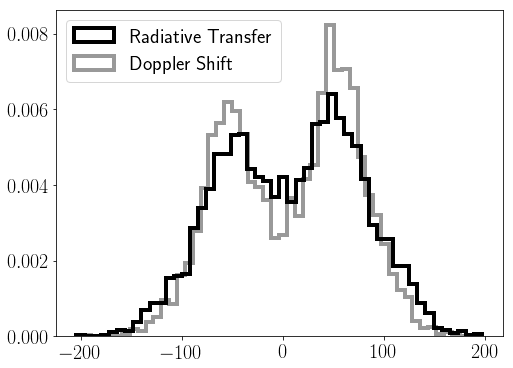

In [6]:
data_A = read_data(vout=5, vrot=0, logtau=5)
data_B = read_data(vout=5, vrot=100, logtau=5)
data_C = doppler_shift(data_A, vrot=100.0)

fig = plt.figure(1, (8., 6.))

mint= np.pi/2.0 -0.05
maxt = np.pi/2.0

x_B, y_B = plot_spectra(data_B, min_theta=mint, max_theta=maxt, lw=4, 
                        label='Radiative Transfer')
x_C, y_C = plot_spectra(data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
                        label='Doppler Shift')
plt.legend(loc=2)

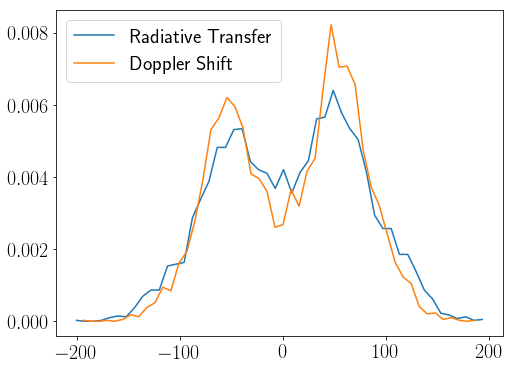

In [7]:
fig = plt.figure(1, (8., 6.))

plt.plot(x_B, y_B, label='Radiative Transfer')
plt.plot(x_C, y_C, label='Doppler Shift')
plt.legend(loc=2)

In [8]:
std_B = np.std(y_B)
std_C = np.std(y_C)

print(std_B, std_C)

0.00206730237631 0.00242304155379


In [9]:
skew_B = skew(y_B)
skew_C = skew(y_C)

print(skew_B, skew_C)

0.21090427466439549 0.549092946155907


# Figure: fig:standard_deviation

In [10]:
def plot_stats(logtau):
    vrot0 = 0
    vrots = [0,50,100]
    vrots_doppler = np.linspace(0, 150, 15)
    vouts = [5,25,50]
    colors = ['b','g','m']

    fig_mn = plt.figure(0, figsize=(20, 10))
    ax_mn = fig_mn.add_subplot(111)
    fig_std = plt.figure(1, figsize=(20, 10))
    ax_std = fig_std.add_subplot(111)
    fig_skw = plt.figure(2, figsize=(20, 10))
    ax_skw = fig_skw.add_subplot(111)

    props = dict(boxstyle='square', facecolor='white')

    for vout, c in zip(vouts, colors):

        data_rot0 = read_data(vout=vout, vrot=vrot0, logtau=logtau)

        x_rt, x_d = [], []

        y_mn_rt, y_mn_d = [], []
        y_std_rt, y_std_d = [], []
        y_skw_rt, y_skw_d = [], []    

        for vrot in vrots:
            data_rot = read_data(vout=vout, vrot=vrot, logtau=logtau)
            y = data_rot['x_frec']

            x_rt.append(vrot)
            y_mn_rt.append(np.mean(y))
            y_std_rt.append(np.std(y))
            y_skw_rt.append(skew(y))

        for vrot_d in vrots_doppler:
            data_doppler = doppler_shift(data_rot0, vrot=vrot_d)
            y = data_doppler['x_frec']

            x_d.append(vrot_d)
            y_mn_d.append(np.mean(y))
            y_std_d.append(np.std(y))
            y_skw_d.append(skew(y))

        vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'    

        # Scatter = Radiative Transfer
        # Plot = Doppler Shift

        ax_mn.scatter(x_rt, y_mn_rt, color=c, marker='o')
        ax_mn.plot(x_d, y_mn_d, label=vout_lab, color=c)

        ax_std.scatter(x_rt, y_std_rt, color=c, marker='o')
        ax_std.plot(x_d, y_std_d, label=vout_lab, color=c)

        ax_skw.scatter(x_rt, y_skw_rt, color=c, marker='o')
        ax_skw.plot(x_d, y_skw_d, label=vout_lab, color=c)

    x_label = r'$v_{\mathrm{rot}}$  ($\mathrm{km}$ $\mathrm{s^{-1}}$)'

    ax_mn.legend()
    ax_std.legend()
    ax_skw.legend()

    ax_mn.set_xlabel(x_label)
    ax_std.set_xlabel(x_label)
    ax_skw.set_xlabel(x_label)

    ax_mn.set_ylabel('Mean Line')
    ax_std.set_ylabel('Standard Deviation')
    ax_skw.set_ylabel('Skewness')

    fig_mn.savefig('./results/mean_line_'+str(logtau)+'.png', format='png', transparent=False, bbox_inches='tight')
    fig_std.savefig('./results/standard_deviation_'+str(logtau)+'.png', format='png', transparent=False, bbox_inches='tight')
    fig_skw.savefig('./results/skewness_'+str(logtau)+'.png', format='png', transparent=False, bbox_inches='tight')

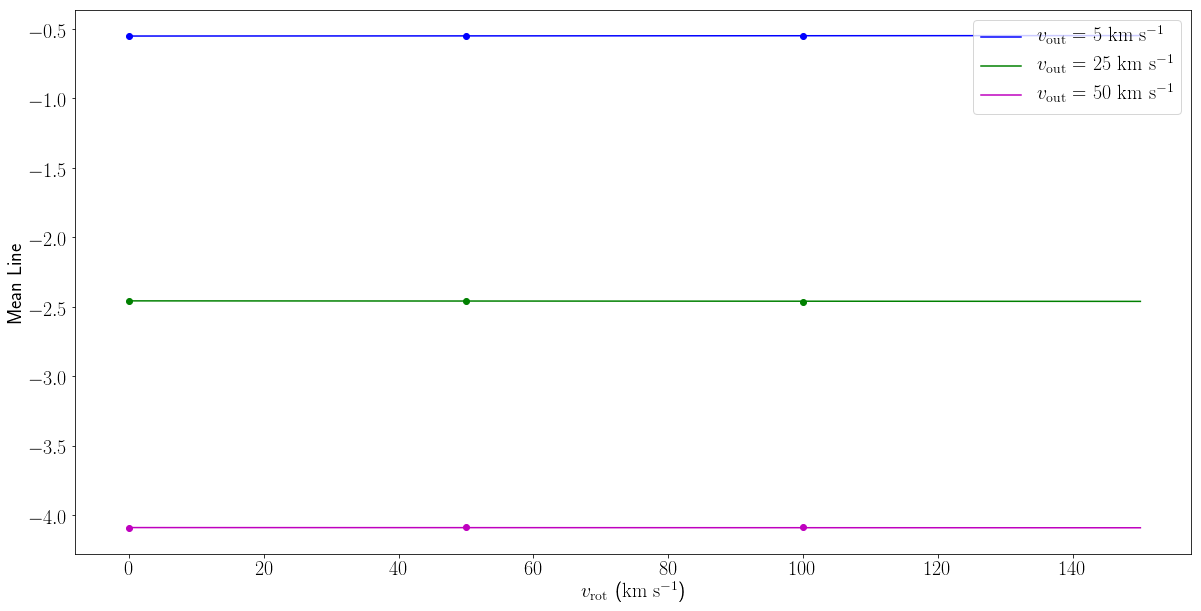

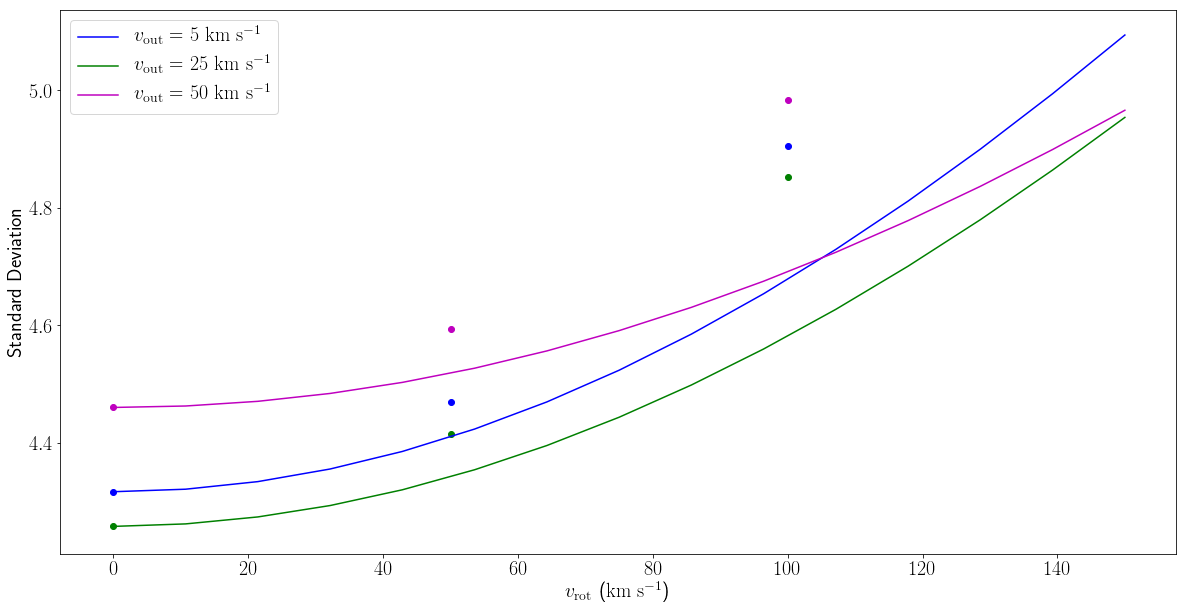

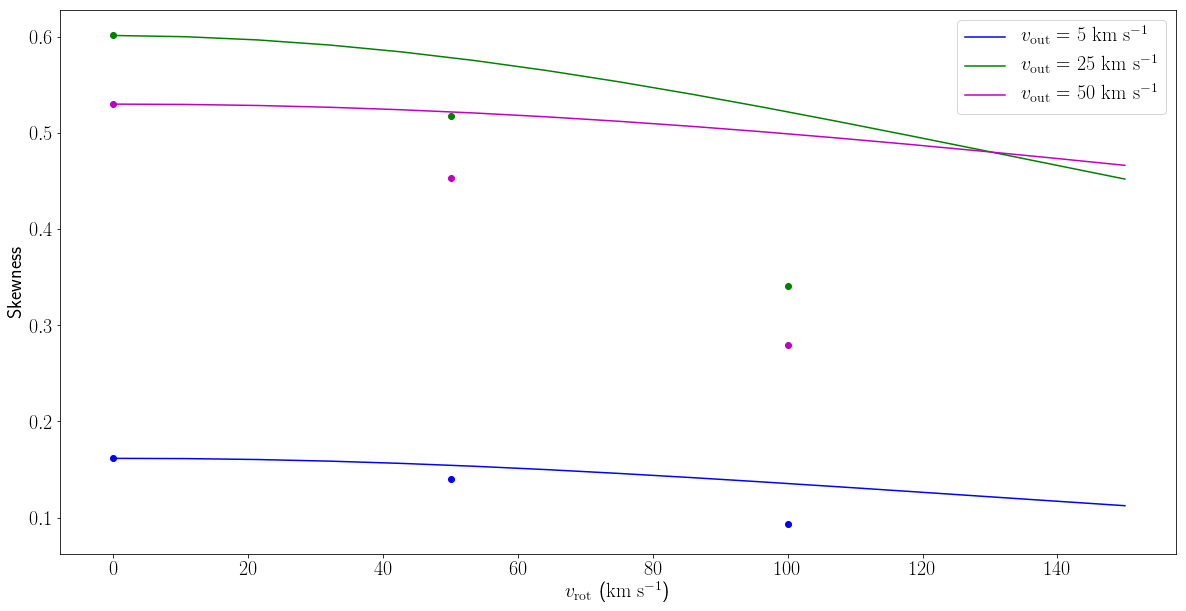

In [11]:
plot_stats(5)

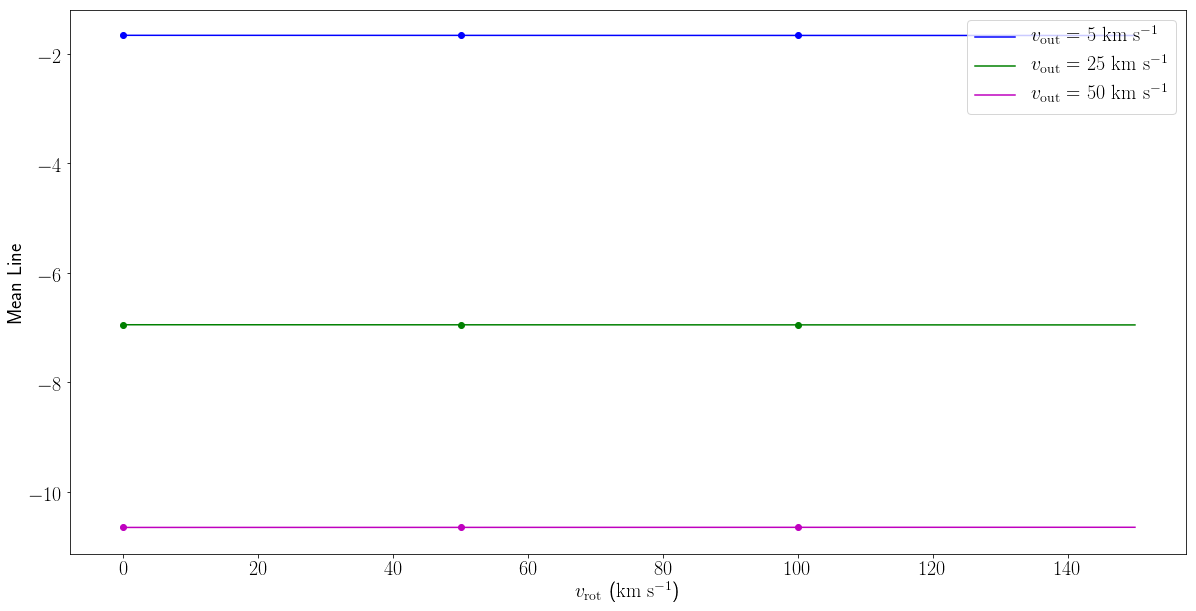

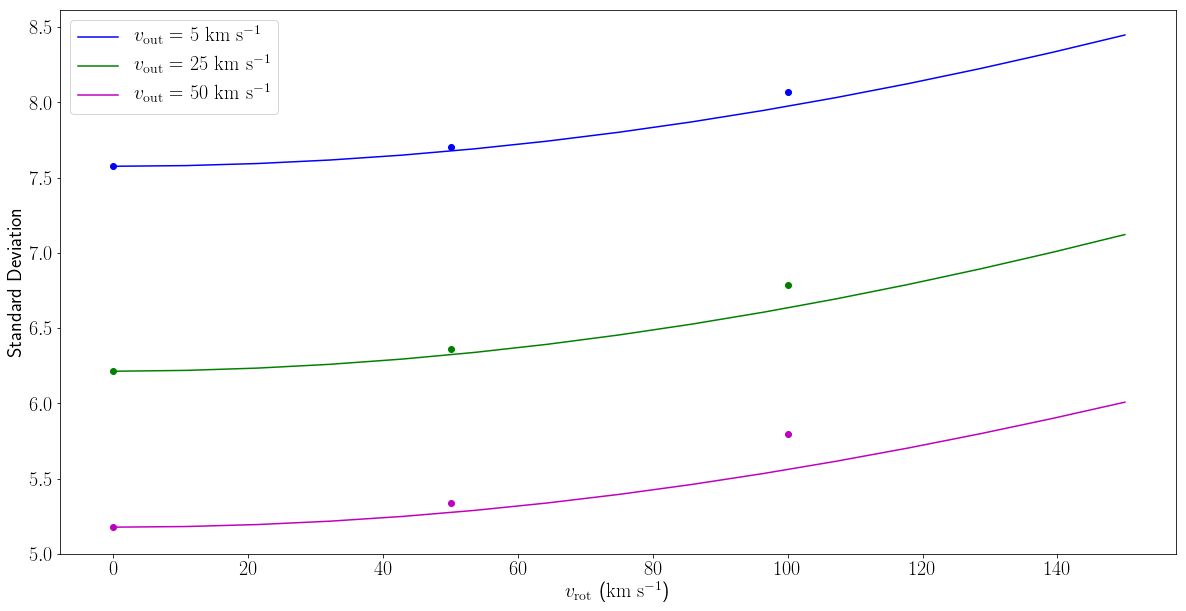

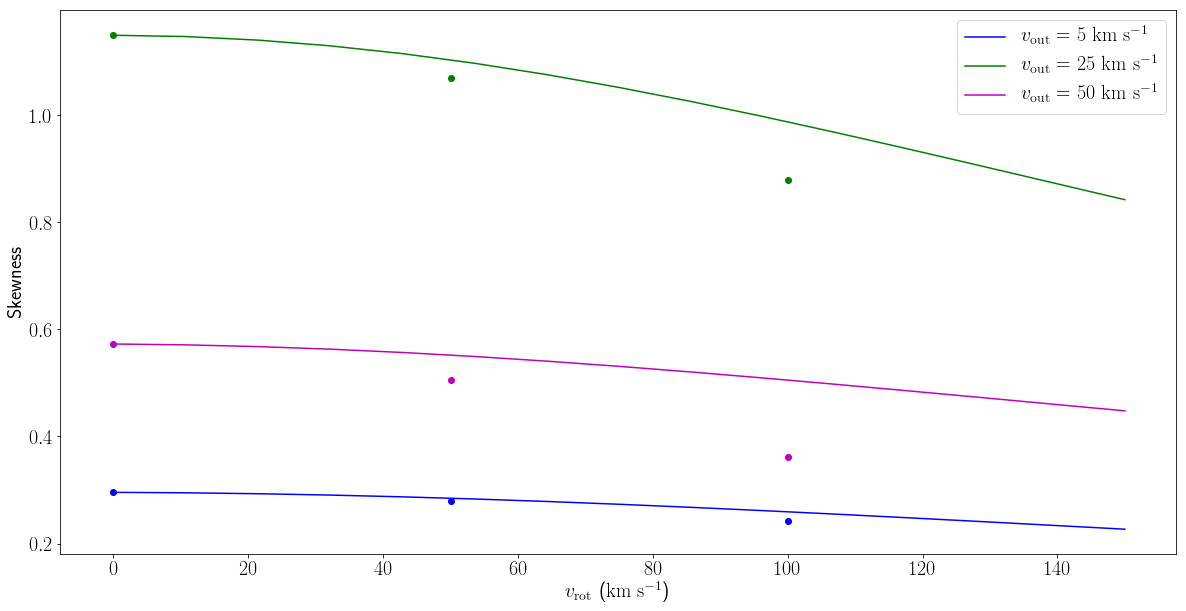

In [12]:
plot_stats(6)

/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


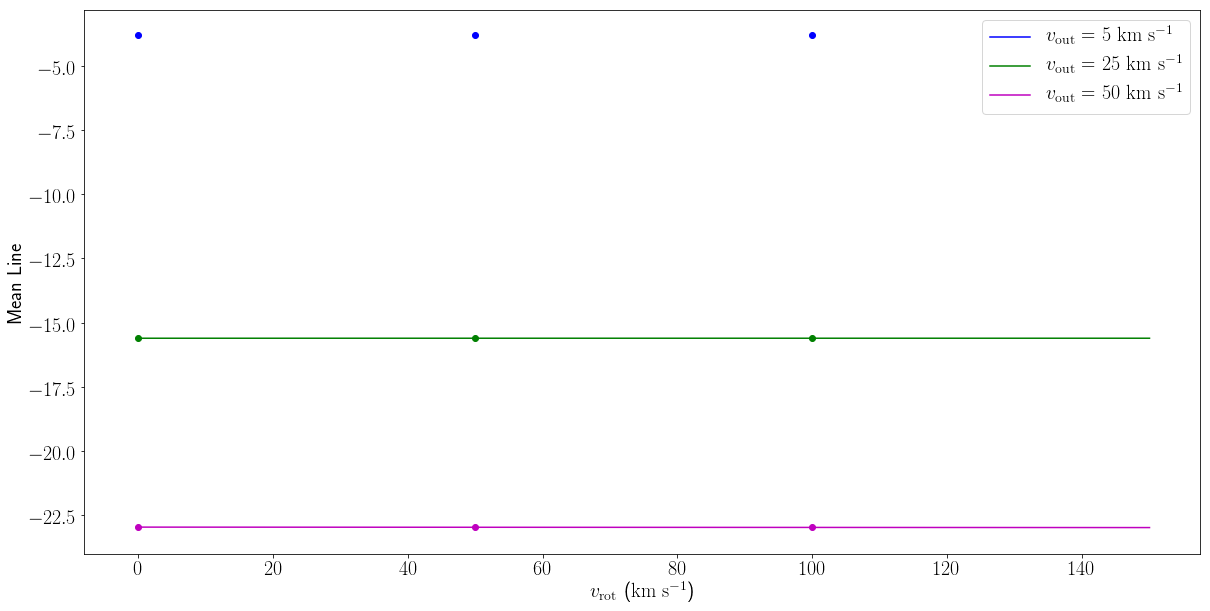

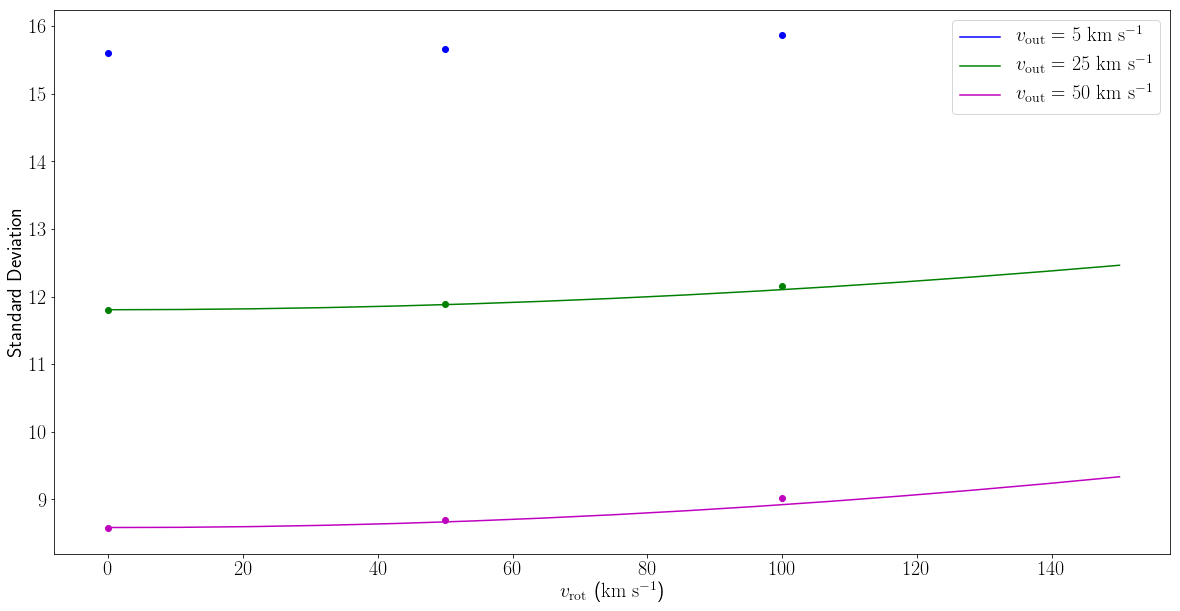

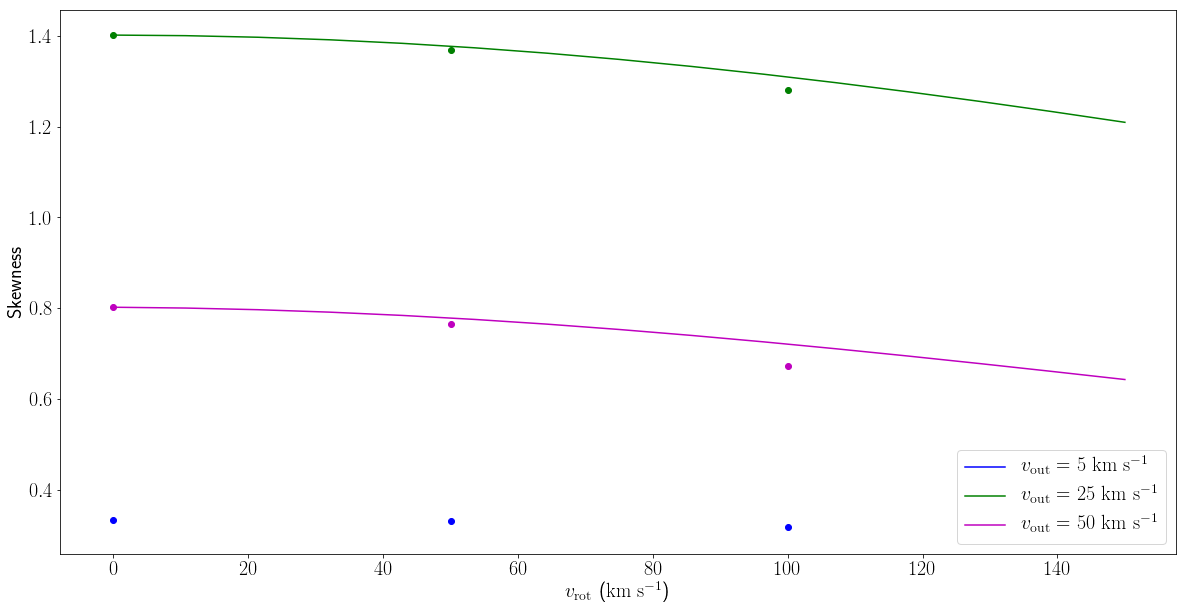

In [15]:
plot_stats(7)